In [2]:
import os
import datetime

from utils.metrics import directional_accuracy_rate
from utils.visualization import plot_predictions

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sqlalchemy import create_engine, sql
from sklearn.preprocessing import StandardScaler

# matplotlib settings
mpl.rcParams["figure.figsize"] = (12, 3)
mpl.rcParams["axes.grid"] = False

# constants
PRINT_RED = '\033[91m'

#--------------------------------------------------------------------------
# Database connection setup
#--------------------------------------------------------------------------

# get postgres environment variables
PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DB_NAME = os.getenv("PG_DB_NAME")
PG_USERNAME = os.getenv("PG_USERNAME")
PG_PASSWORD = os.getenv("PG_PASSWORD")

# check for missing environment variables
if PG_HOST == None or PG_PORT == None or PG_DB_NAME == None or PG_USERNAME == None or PG_PASSWORD == None:
    print(f'{PRINT_RED}[ ERROR ] Environment variables PG_HOST, PG_PORT, PG_DB_NAME, PG_USERNAME, or PG_PASSWORD not found.')

# hard-code table name
PG_MINUTE_BARS_TABLE = "bars_minute_eastern"
PG_DAY_BARS_TABLE = "bars_day"

# connect to db and open a cursor to perform database operations
conn_string = f"postgresql://{PG_USERNAME}:{PG_PASSWORD}@{PG_HOST}:{PG_PORT}/{PG_DB_NAME}"
db = create_engine(conn_string)
conn = db.connect()

In [3]:
#------------------------------------------------------------------------------
# Pull data from db and wrangle into correct shape
# (minute bars for NVDA from 09:00-14:00 from 2022/06/01-2022/07/01)
#------------------------------------------------------------------------------

# create empty dataframe to hold bar data
days_data_df = pd.DataFrame(columns=["date", "minute_bars"])

# create empty dataframe to hold timestamp data
days_timestamps_df = pd.DataFrame(columns=["date", "timestamp"])

# NOTE: db contains minute bars for NVDA,INTC from 2022/06/01 to 2022/07/01 (inclusive)
start_date = datetime.date(2022, 6, 1)
end_date = datetime.date(2022, 7, 1)

volume_scaler = StandardScaler()

current_date = start_date
day_delta = datetime.timedelta(days=1)

# get previous date's day_bar and minute_bars
previous_day_minute_bars_df = pd.read_sql_query(
    sql=sql.text(f"select * from { PG_MINUTE_BARS_TABLE } where SYMBOL='NVDA' and date(TIMESTAMP)='{ current_date - day_delta }'"),
    con=conn,
)
previous_day_bar_df = pd.read_sql_query(
    sql=sql.text(f"select * from { PG_DAY_BARS_TABLE } where SYMBOL='NVDA' and date(DATE)='{ current_date - day_delta }'"),
    con=conn,
)

# loop over each date and get minute_bars from db
while current_date <= end_date:
    # get current date's day_bar and minute_bars
    day_minute_bars_df = pd.read_sql_query(
        sql=sql.text(f"select * from { PG_MINUTE_BARS_TABLE } where SYMBOL='NVDA' and date(TIMESTAMP)='{ current_date }'"),
        con=conn,
    )
    day_bar_df = pd.read_sql_query(
        sql=sql.text(f"select * from { PG_DAY_BARS_TABLE } where SYMBOL='NVDA' and date(DATE)='{ current_date }'"),
        con=conn,
    )

    # skip day if empty
    if day_minute_bars_df.empty:
        current_date += day_delta
        continue

    # drop symbol column
    day_minute_bars_df.drop("symbol", axis=1, inplace=True)

    # get high and low from previous day
    high = previous_day_bar_df['high'].iloc[0]
    low = previous_day_bar_df['low'].iloc[0]

    # standardize volume using yesterday's data
    volume_scaler.fit(np.reshape(previous_day_minute_bars_df['volume'].values, (-1, 1)))
    standardized_volume = volume_scaler.transform(np.reshape(day_minute_bars_df['volume'].values, (-1, 1)))
    day_minute_bars_df['z_volume'] = standardized_volume

    #----------------------------------------------------------------------
    # Convert timestamps to day/week/year sin and cosine signals
    #----------------------------------------------------------------------

    # extract timestamps
    timestamps = pd.to_datetime(day_minute_bars_df.pop("timestamp"))

    timestamp_s = timestamps.map(pd.Timestamp.timestamp)

    seconds_per_day = 24 * 60 * 60
    seconds_per_week = seconds_per_day * 7
    seconds_per_year = seconds_per_week * 52.1429

    day_minute_bars_df["day-sin"] = np.sin(timestamp_s * (2 * np.pi / seconds_per_day))
    day_minute_bars_df["day-cos"] = np.cos(timestamp_s * (2 * np.pi / seconds_per_day))

    day_minute_bars_df["week-sin"] = np.sin(timestamp_s * (2 * np.pi / seconds_per_week))
    day_minute_bars_df["week-cos"] = np.cos(timestamp_s * (2 * np.pi / seconds_per_week))

    day_minute_bars_df["year-sin"] = np.sin(timestamp_s * (2 * np.pi / seconds_per_year))
    day_minute_bars_df["year-cos"] = np.cos(timestamp_s * (2 * np.pi / seconds_per_year))

    # insert day minute bars and timestamps to their respecive dataframes
    days_data_df.loc[len(days_data_df), days_data_df.columns] = current_date, day_minute_bars_df
    days_timestamps_df.loc[len(days_timestamps_df), days_timestamps_df.columns] = current_date, timestamps

    # shift current day bars to previous day
    previous_day_minute_bars_df = day_minute_bars_df
    previous_day_bar_df = day_bar_df

    # go to next day
    current_date += day_delta

In [4]:
#------------------------------------------------------------------------------
# Drop volume columns
#------------------------------------------------------------------------------

for _, day_data_df in days_data_df.iterrows():
    day_data_df["minute_bars"].drop("volume", axis=1, inplace=True)

#------------------------------------------------------------------------------
# Split into training/validation (70%), validation (20%), and test (10%) sets
#------------------------------------------------------------------------------

n = len(days_data_df)  # total number of days

days_train_df = days_data_df[0 : int(n * 0.7)]
days_val_df = days_data_df[int(n * 0.7) : int(n * 0.9)]
days_test_df = days_data_df[int(n * 0.9) :]

In [5]:
#-----------------------------------------------------------------------------
# Create and train a convolutional model
#-----------------------------------------------------------------------------

N_FEATURES = len(days_data_df.iloc[0]['minute_bars'].columns)
INPUT_WINDOW_LEN = 4
BATCH_SIZE = 32 # not much clue what this does
CONV_WIDTH = 3 # no clue what this does
EPOCHS = 100 # no clue what this does
FILTERS = 32 # no clue what this does

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=FILTERS, kernel_size=CONV_WIDTH, activation='relu', input_shape=(INPUT_WINDOW_LEN, N_FEATURES)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='linear'),
])

conv_model.compile(
    loss=tf.keras.losses.MeanSquaredError(), # Computes the mean of squares of errors between labels and predictions.
    optimizer=tf.keras.optimizers.Adam(), # Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
    metrics=[tf.keras.metrics.MeanAbsoluteError()], # Computes the mean of absolute difference between labels and predictions.
)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-28 23:22:23.930576: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-28 23:22:23.930720: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
# loop over training days to fit the model
for index, day_data in days_train_df.iterrows():
    print(days_data_df.iloc[index]['date'])

    # Extract the minute bars for this day
    minute_bars = day_data["minute_bars"].values

    # Extract the target variable (which we want to predict) from the minute bars
    targets = day_data["minute_bars"]['close'].values[INPUT_WINDOW_LEN:]

    minute_bars_indexes = [[i + j for j in range(INPUT_WINDOW_LEN)] for i in range(len(minute_bars) - INPUT_WINDOW_LEN)]

    minute_bars_windows = minute_bars[minute_bars_indexes]

    # Fit the model to the training data
    conv_model.fit(
        x=minute_bars_windows,
        y=targets,
        epochs=EPOCHS,
        verbose=1,
        batch_size=BATCH_SIZE,
    )

2022-06-01
Epoch 1/100


2023-04-28 23:22:24.127434: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-28 23:22:24.311169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 41ms/step - loss: 45297.5273 - mean_absolute_error: 211.7445
Epoch 2/100
14/14 [==============================] - 0s 7ms/step - loss: 18009.4844 - mean_absolute_error: 132.1496
Epoch 3/100
14/14 [==============================] - 0s 6ms/step - loss: 3014.8809 - mean_absolute_error: 51.1674
Epoch 4/100
14/14 [==============================] - 0s 6ms/step - loss: 132.5024 - mean_absolute_error: 10.1473
Epoch 5/100
14/14 [==============================] - 0s 7ms/step - loss: 172.6653 - mean_absolute_error: 12.4654
Epoch 6/100
14/14 [==============================] - 0s 9ms/step - loss: 9.8674 - mean_absolute_error: 2.7964
Epoch 7/100
14/14 [==============================] - 0s 8ms/step - loss: 9.7104 - mean_absolute_error: 2.8452
Epoch 8/100
14/14 [==============================] - 0s 7ms/step - loss: 1.1530 - mean_absolute_error: 0.9227
Epoch 9/100
14/14 [==============================] - 0s 7ms/step - loss: 0.5751 - mean_absolute_error: 0.6135

2022-06-23


2023-04-28 23:24:44.779174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-28 23:24:44.935426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test loss: 0.19464707374572754, Test MAE: 0.28427502512931824


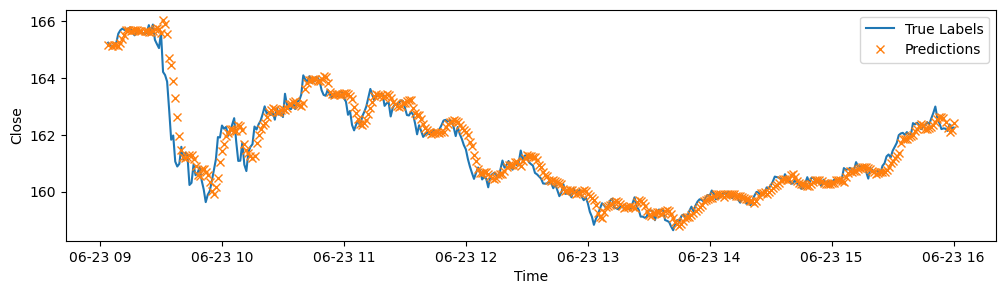

2022-06-24
Test loss: 0.0979873314499855, Test MAE: 0.21196576952934265


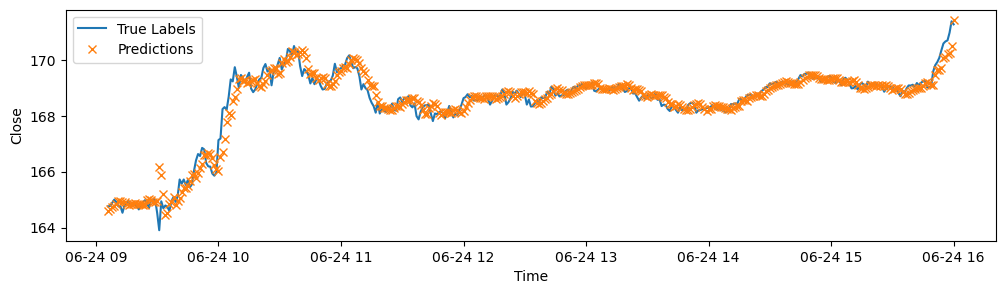

2022-06-27
Test loss: 0.22545655071735382, Test MAE: 0.3015662431716919


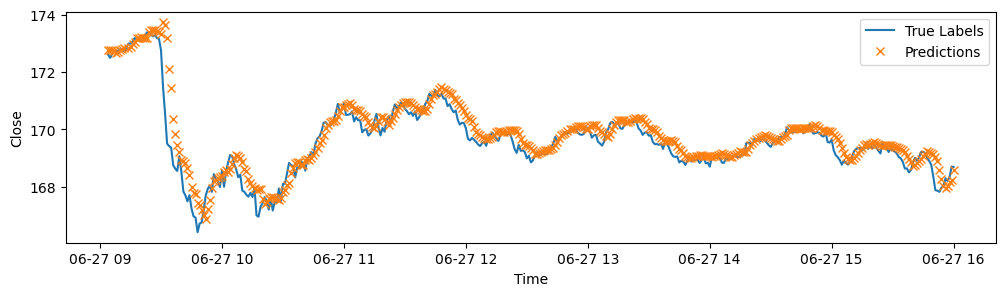

2022-06-28
Test loss: 0.19072476029396057, Test MAE: 0.3308260142803192


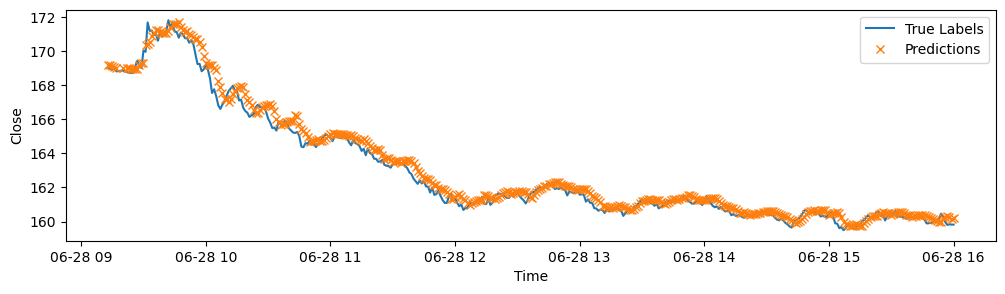

Directional Accuracy Rate: 0.48975782045561167


In [7]:
summed_directional_accuracy_rate = 0
n_days = 0

for index, day_data in days_val_df.iterrows():
    print(days_data_df.iloc[index]['date'])

    # Extract the minute bars for this day
    minute_bars = day_data["minute_bars"].values

    # Extract the target variable (which we want to predict) from the minute bars
    inputs = day_data["minute_bars"]['close'].values[INPUT_WINDOW_LEN-1:-1]
    targets = day_data["minute_bars"]['close'].values[INPUT_WINDOW_LEN:]

    minute_bars_indexes = [[i + j for j in range(INPUT_WINDOW_LEN)] for i in range(len(minute_bars) - INPUT_WINDOW_LEN)]

    minute_bars_windows = minute_bars[minute_bars_indexes]
    
    # Evaluate the model on the test data
    loss, mae = conv_model.evaluate(x=minute_bars_windows, y=targets, verbose=0)
    print(f"Test loss: {loss}, Test MAE: {mae}")
    
    predictions = conv_model.predict(x=minute_bars_windows, verbose=0, steps=None).flatten()

    summed_directional_accuracy_rate += directional_accuracy_rate(inputs=inputs, labels=targets, predictions=predictions)
    n_days += 1

    plot_predictions(labels=targets, predictions=predictions, timestamps=days_timestamps_df.iloc[index]['timestamp'].values[INPUT_WINDOW_LEN:])

print(f'Directional Accuracy Rate: {summed_directional_accuracy_rate / n_days}')